## Week 1

### Jiyi's explanation: 

e.g. Face verifacation: face + name -> T/F

Apply distance-preserving transformation to face (to protect privacy), so we cannot see the picture of one's face.

Prove we may get the gender of the person from the transfromed face.

## Adversarial ML
For context, there are many categories of adversarial attacks, each with a different goal and assumption of the attacker’s knowledge. However, in general the overarching goal is to **add the least amount of perturbation to the input data** to cause the **desired misclassification**.
### Assumptions of the attacker’s knowledge
#### white-box attack  
Assumes the attacker has full knowledge and access to the model, including **architecture, inputs, outputs, and weights**.
#### black-box attack  
Assumes the attacker only has access to the **inputs and outputs** of the model, and knows nothing about the underlying architecture or weights. 
### Goals
#### misclassification   
The adversary only wants the output classification to be wrong but does not care what the new classification is.
#### source/target misclassification  
The adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.
### Fast Gradient Sign Attack (FGSM)
The FGSM attack is a white-box attack with the goal of misclassification.  
The attack uses the gradient of the loss w.r.t the input data, then **adjusts the input data to maximize the loss**.

Reference:  
https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [10]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "models/lenet_mnist_model.pth"

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [46]:
test_dataset = datasets.MNIST('../data', train=False, download=True, 
                              transform=transforms.Compose([transforms.ToTensor(),]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

device = torch.device("cpu")
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [13]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


## Distance Preserving Transformation
t-Distributed Stochastic Neighbor Embedding (t-SNE) is an **unsupervised, non-linear** technique primarily used for **data exploration and visualizing high-dimensional data**.

The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. It looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions.

It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.    
### Use Cases
- t-SNE could be used on high-dimensional data and then the output of those dimensions then become inputs to some other classification model.  
- t-SNE could be used to investigate, learn, or evaluate segmentation.  
- t-SNE however is not a clustering approach since it does not preserve the inputs like PCA and the values may often change between runs so it’s purely for exploration.  

Reference:   
https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1  
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [66]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [54]:
data_array = test_dataset.data.numpy()
target_array = test_dataset.targets.numpy()
num = data_array.shape[0]
data = data_array.reshape(num, -1)
target = target_array.reshape(num, -1)

In [55]:
data_embedded = TSNE(n_components=2).fit_transform(data)

In [65]:
feat_cols = [ 'pixel'+str(i) for i in range(data.shape[1]) ]
df = pd.DataFrame(data,columns=feat_cols)
df['y'] = target
df['label'] = df['y'].apply(lambda i: str(i))

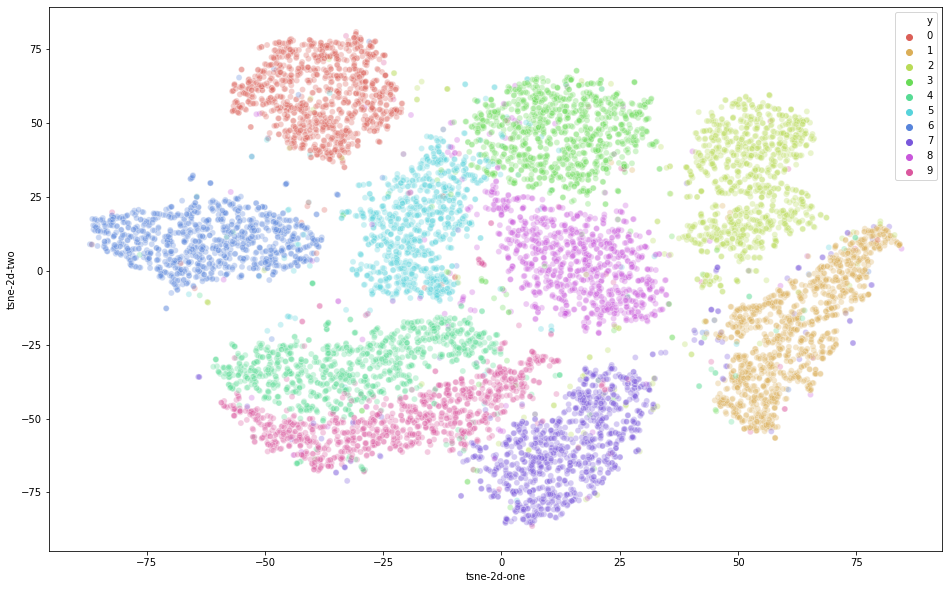

In [67]:
df['tsne-2d-one'] = data_embedded[:,0]
df['tsne-2d-two'] = data_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

Consider t-SNE as a transformation and the clustering as 'distance', we can see the clustering is preserved after t-SNE is applied. This can be considered as a relaxed distance preserving transformation.

After the transformation, we no longer know about the original pixels and thus the information about what the number is. However, we can still distinguish they're different numbers, i.e. some information is leaked.